In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import common

In [5]:
data_set_path = "../temp_sets_100/"

# Outputevents

## Read samples

In [6]:
outputevents_df = common.read_csv_no_rowid(data_set_path + "outputevents.csv")

In [7]:
outputevents_df.head()

,subject_id,hadm_id,icustay_id,charttime,itemid,value,valueuom,storetime,cgid,stopped,newbottle,iserror
0,44346,140114,250021,2165-04-07 17:00:00,226559,50.0,mL,2165-04-07 17:19:00,14542,NaN,NaN,NaN
1,44346,140114,250021,2165-04-10 11:00:00,226600,15.0,mL,2165-04-10 11:02:00,14542,NaN,NaN,NaN
2,44346,140114,250021,2165-04-10 15:00:00,226600,10.0,mL,2165-04-10 15:15:00,14542,NaN,NaN,NaN
3,44346,140114,250021,2165-04-11 03:41:00,226600,30.0,mL,2165-04-11 03:41:00,20714,NaN,NaN,NaN
4,44346,140114,250021,2165-04-11 08:00:00,226600,5.0,mL,2165-04-11 08:19:00,14542,NaN,NaN,NaN


## Data pre-process

In [8]:
# outputevents_df.dropna(subset=['hadm_id'], inplace=True, axis=0)
# outputevents_df.dropna(subset=['icustay_id'], inplace=True, axis=0)

In [9]:
outputevents_df.drop(['valueuom', 'storetime', 'cgid', 'stopped', 'newbottle', 'iserror'], axis=1, inplace=True)

### Process missing values

In [10]:
common.nan_count(outputevents_df)

Total columns: 6
Total rows: 14667
--------------
subject_id      0
hadm_id         0
icustay_id      0
charttime       0
itemid          0
value         415
dtype: int64


In [11]:
outputevents_df.dropna(subset=['value'], inplace=True, axis=0)

In [12]:
common.nan_count(outputevents_df)

Total columns: 6
Total rows: 14252
--------------
subject_id    0
hadm_id       0
icustay_id    0
charttime     0
itemid        0
value         0
dtype: int64


### Set the column types

In [13]:
outputevents_df.dtypes

subject_id      int64
hadm_id         int64
icustay_id      int64
charttime      object
itemid          int64
value         float64
dtype: object

In [14]:
outputevents_df['charttime'] = pd.to_datetime(outputevents_df['charttime'])

In [15]:
outputevents_df.dtypes

subject_id             int64
hadm_id                int64
icustay_id             int64
charttime     datetime64[ns]
itemid                 int64
value                float64
dtype: object

### Process time value

In [16]:
icustays_df = common.read_csv_no_rowid(data_set_path+"icustays.csv")

In [17]:
icu_intime_df = icustays_df.loc[:, ['icustay_id', 'intime']]
icu_intime_df['intime'] = pd.to_datetime(icu_intime_df['intime'])

In [18]:
outputevents_mid_df = pd.merge(left=outputevents_df, right=icu_intime_df, how='left', on=['icustay_id'])

In [19]:
outputevents_mid_df.dtypes

subject_id             int64
hadm_id                int64
icustay_id             int64
charttime     datetime64[ns]
itemid                 int64
value                float64
intime        datetime64[ns]
dtype: object

In [20]:
outputevents_mid_df['charttime'] = outputevents_mid_df.apply(common.time_process, args=('intime', 'charttime'), axis=1)
outputevents_mid_df['charttime'] = outputevents_mid_df['charttime'].astype(np.int64)

In [21]:
outputevents_df = outputevents_mid_df.drop(['subject_id', 'hadm_id', 'icustay_id', 'intime'], axis=1)

In [22]:
outputevents_df.columns

Index(['charttime', 'itemid', 'value'], dtype='object')

---
## Build model

### Set constraints

In [28]:
from sdv.constraints import FixedCombinations

fixed_item_value_linkorderid_constraint = FixedCombinations(
    column_names=['itemid', 'value']
)

In [29]:
constraints = [fixed_item_value_linkorderid_constraint]

### Build model

In [30]:
train_data = outputevents_df
best_model = common.build_model(constraints=constraints, train_data=train_data)

In [ ]:
model_save_path = data_set_path + "100_models/" + "outputevents_model.pkl"
common.save_model(best_model, model_save_path)

---

## Evaluate data

### Generate synthetic data

In [ ]:
date_load_path = data_set_path + "100_models/" + "outputevents_model.pkl"
model = common.load_model(date_load_path)

In [ ]:
sample = model.sample(num_rows=len(train_data))

### Evaluation

In [ ]:
from sdv.evaluation import evaluate

In [ ]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

nan

In [ ]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.5084849804572503

In [ ]:
evaluate(sample, train_data)

<AxesSubplot:xlabel='itemid', ylabel='value'>

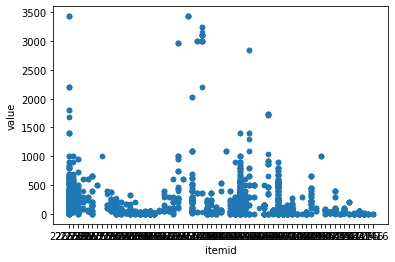

In [ ]:
sample.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:xlabel='itemid', ylabel='value'>

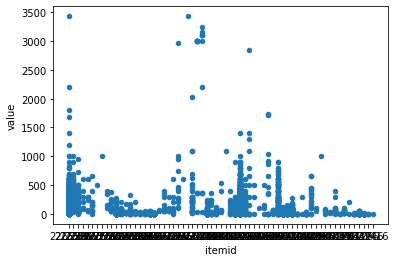

In [ ]:
train_data.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

In [ ]:
# evaluate(sample, train_data, aggregate=False)